In [1]:
from psyke import Extractor
from psyke.utils import Target

from sklearn.datasets import load_iris, load_wine
from sklearn.metrics import adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI, \
    v_measure_score as V_score, fowlkes_mallows_score as FM
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import cycle, islice
import warnings
warnings.filterwarnings('ignore')

In [131]:
def gradientbars(bars):
    maxY = max([bar.get_height() for bar in bars])
    ax = bars[0].axes
    lim = ax.get_xlim() + ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor('none')
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0, h / maxY, 256)).T
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect='auto', zorder=0,
                  norm=mpl.colors.NoNorm(vmin=0, vmax=1), origin='lower')
    ax.axis(lim)

def get_colors(y):
    colors = np.array(list(islice(cycle(
        ["limegreen", "red", "mediumturquoise", "mediumvioletred", "goldenrod"]),
        int(max(y) + 1)))
    )
    return np.append(colors, ["#000000"])

def get_colors2(y):
    colors = np.array(list(islice(cycle(
        ["teal", "mediumvioletred", "goldenrod", "limegreen", "mediumturquoise"]),
        int(max(y) + 1)))
    )
    return np.append(colors, ["#000000"])

def print_plot(x, y, text, v, al='left'):
    plt.text(x, y, f"{text}={abs(v):.2f}", size=13, transform=plt.gca().transAxes, horizontalalignment=al)

def plot(X, y, ari=None, ami=None, v=None, fm=None, fun=get_colors):
    if isinstance(y[0], float):
        plt.scatter(X[:, 0], X[:, 1], s=10, c=y, cmap='winter')
    else:
        plt.scatter(X[:, 0], X[:, 1], s=10, color=fun(y)[y])
    #plt.xlim(min(X[:, 0]), max(X[:, 0]))
    #plt.ylim(min(X[:, 1]), max(X[:, 1]))
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    if ami is not None:
        print_plot(0.99, 0.02, "AMI", ami, 'right')
    if ari is not None:
        print_plot(0.01, 0.02, "ARI", ari)
    if v is not None:
        print_plot(0.99, 0.92, "V", v, 'right')
    if fm is not None:
        print_plot(0.01, 0.92, "FM", fm)
    return 1

In [111]:
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

random_state = 170
# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

default_base = {"quantile": 0.3, "eps": 0.3, "damping": 0.9, "preference": -200, "n_neighbors": 3, "n_clusters": 3,
                "min_samples": 7, "xi": 0.05, "min_cluster_size": 0.1, "criterion": "density", "radius": 0.31,
                "n_points": 10, "target": Target.CLASSIFICATION, 'e_th': 0.01, 'c_th': 0.01, 'e_d': 5, 'c_d': 5}

data1 = [
    (noisy_circles, {
        "damping": 0.77, "preference": -240, "quantile": 0.2, "n_clusters": 2, "min_samples": 7, "xi": 0.08
    }, 'DS1'),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2, "min_samples": 7, "xi": 0.1}, 'DS2'),
    (varied, {"eps": 0.18, "n_neighbors": 2, "min_samples": 7, "xi": 0.01, "min_cluster_size": 0.2, "radius": .18},
     'DS3'),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}, 'DS4')
]

ccpp = pd.read_csv("../test/resources/datasets/CCPP.csv", sep=";", decimal=",").sample(frac=.25, ignore_index=True)
ise = pd.read_csv("../test/resources/datasets/akbilgic.csv").drop(['date', 'ISE(TL)'], axis=1)
iris = load_iris(return_X_y=True, as_frame=True)
wine = load_wine(return_X_y=True, as_frame=True)

data2= [
    ((iris[0][list(iris[0].columns[2:]) + list(iris[0].columns[:2])], iris[1]),
     {"radius": 0.27, "n_points": 10}, 'Iris'),
    ((wine[0][[wine[0].columns[-1], wine[0].columns[0]] + list(wine[0].columns[1:-1])], wine[1]),
     {"radius": 0.5247, "n_points": 8}, 'Wine'),
    ((ccpp.iloc[:, :-1], ccpp.iloc[:, -1]), {"target": Target.REGRESSION}, 'CCPP'),
    ((ise[[ise.columns[3], ise.columns[6]] + list(ise.columns[1:3]) + list(ise.columns[4:6]) + [ise.columns[7]]],
      ise[ise.columns[0]]), {"target": Target.REGRESSION}, 'ISE')
]

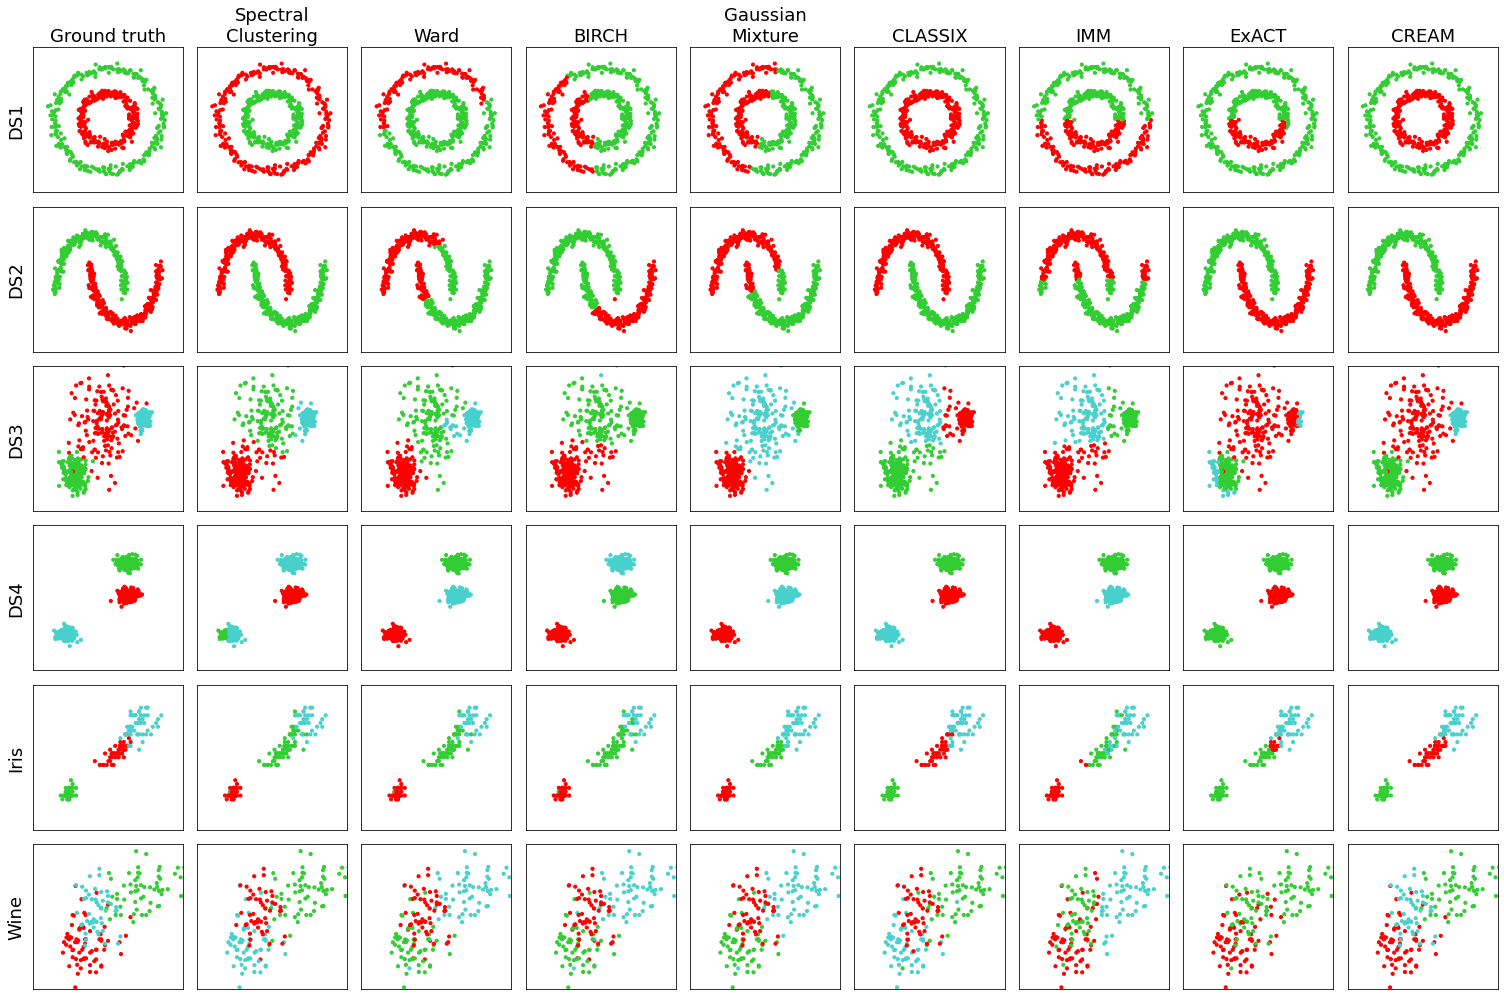

In [9]:
data = {}

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(2.1 * 10, 14))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01)

plot_num = 1

for i_dataset, (dataset, algo_params, name) in enumerate(data1 + data2):
    data[i_dataset] = {}
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    clx = Extractor.classix(radius=params["radius"], minPts=params["n_points"],
                            group_merging_mode=params["criterion"], reassign_outliers=True)
    imm = Extractor.imm(params["n_clusters"])
    exact = Extractor.exact(5, 0.01, Target.CLASSIFICATION, gauss_components=3)
    cream = Extractor.cream(5, 0.01, Target.CLASSIFICATION, gauss_components=3)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )

    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        #("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        #("DBSCAN", dbscan),
        #("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
        ("CLASSIX", clx),
        ("IMM", imm),
        ("ExACT", exact),
        ('CREAM', cream)
    )

    plt.subplot(len(data1 + data2), len(clustering_algorithms) + 1, plot_num)
    if i_dataset == 0:
        plt.title("Ground truth", size=18)
    plt.ylabel(f"{name}", fontsize=18)

    plot_num += plot(X, y)

    for name, algorithm in clustering_algorithms:
        data[i_dataset][name] = []

        Xpd = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1, ignore_index=True).dropna()

        t0 = time.time()
        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            if name in ['ExACT', 'CREAM']:
                algorithm.fit(Xpd)
            else:
                algorithm.fit(X)
        t1 = time.time()

        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            if name in ['ExACT', 'CREAM']:
                y_pred = algorithm.predict(pd.DataFrame(X))
            else:
                y_pred = algorithm.predict(X)

        plt.subplot(len(data1 + data2), len(clustering_algorithms) + 1, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        data[i_dataset][name] = [ARI(y, y_pred), AMI(y, y_pred), V_score(y, y_pred), FM(y, y_pred), t1 - t0]
        plot_num += plot(X, y_pred)#, ARI(y, y_pred), AMI(y, y_pred), V_score(y, y_pred), FM(y, y_pred))
plt.tight_layout()
plt.savefig("clust1.pdf", dpi=500)
plt.show()

In [15]:
data[0]['CREAM'][-1] /= 2

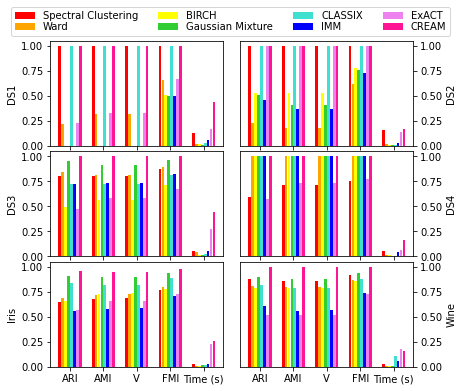

In [16]:
xax = [i[-1] for i in data1 + data2]
colors = ['red', 'orange', 'yellow', 'limegreen', 'turquoise', 'blue', 'violet', 'deeppink']

w = .3
x = np.array([i * w * 1.05 for i in range(8)])
offset = w * 12

plot_num = 1

plt.figure(figsize=(6.5, 6))

for j, name in enumerate(xax):
    plt.subplot(3, 2, plot_num)
    plot_num += 1

    Y = {}
    for i in range(5):
        Y[i] = [v[i] for v in data[j].values()]

    for i in range(5):
        plt.bar(x + offset * i, Y[i], width=w, color=colors)

    plt.xlabel("")
    plt.ylabel(name)
    plt.ylim((0, 1.05))
    plt.gca().set_xticks([(x[3] + x[4]) / 2 + offset * i for i in range(5)])
    plt.gca().set_xticklabels(["ARI", "AMI", "V", "FMI", "Time (s)"])
    if j % 2 == 1:
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
    if j == 0:
        bars = [plt.bar(-1, 0, 0, color=colors[i]) for i, _ in enumerate(data[j].keys())]
        lgd = plt.figlegend(bars, [k.replace('\n', ' ') for k in data[j].keys()], loc='upper center',
                            ncol=4, labelspacing=0.1, bbox_to_anchor = (.51, .97))
#plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.savefig("clust_perf.pdf", dpi=500, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

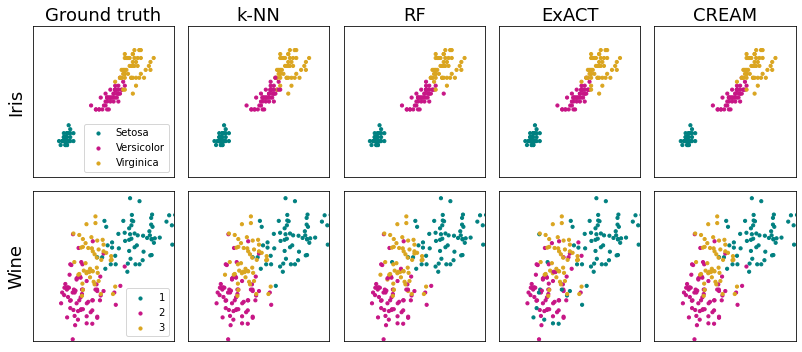

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

data = {}

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(2.25 * 5, 5))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01)

plot_num = 1

for i_dataset, (dataset, algo_params, name) in enumerate(data2[:2]):
    data[i_dataset] = {}
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    X = np.array(X)

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    knn = KNeighborsClassifier(11)
    dt = DecisionTreeClassifier(max_leaf_nodes=3)
    rf = RandomForestClassifier(n_estimators=10,max_leaf_nodes=3)
    exact = Extractor.exact(params["e_d"], params["e_th"], params["target"], gauss_components=2)
    cream = Extractor.cream(params["c_d"], params["c_th"], params["target"], gauss_components=3)

    clustering_algorithms = (
        ("k-NN", knn),
        #("DT", dt),
        ("RF", rf),
        ("ExACT", exact),
        ('CREAM', cream)
    )

    plt.subplot(2, len(clustering_algorithms) + 1, plot_num)
    if i_dataset == 0:
        plt.title("Ground truth", size=18)
    plt.ylabel(f"{name}", fontsize=18)

    labels = ['Setosa', 'Versicolor', 'Virginica'] if name == 'Iris' else ['1', '2', '3']
    for i, l in enumerate(labels):
        plt.scatter(10, 0, s=10, color=get_colors2(y)[i], label=l)
    plt.legend()

    plot_num += plot(X, y, fun=get_colors2)

    for name, algorithm in clustering_algorithms:
        data[i_dataset][name] = []

        t0 = time.time()
        if name in ['ExACT', 'CREAM']:
            algorithm.fit(pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1, ignore_index=True).dropna())
            # algorithm.explain()
        else:
            algorithm.fit(X, y)
        t1 = time.time()

        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            if name in ['ExACT', 'CREAM']:
                y_pred = algorithm.predict(pd.DataFrame(X))
            else:
                y_pred = algorithm.predict(X)

        plt.subplot(2, len(clustering_algorithms) + 1, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        data[i_dataset][name] = accuracy_score(y, y_pred)
        plot_num += plot(X, y_pred, fun=get_colors2)
plt.tight_layout()
plt.savefig("class.pdf", dpi=500)
plt.show()

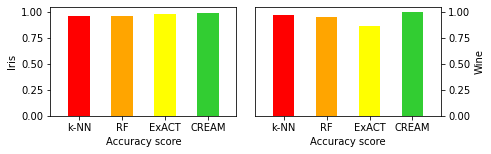

In [126]:
colors = ['red', 'orange', 'yellow', 'limegreen', 'turquoise', 'blue', 'violet', 'deeppink']
w = .15
l = len(clustering_algorithms)
xax = [i[0] for i in clustering_algorithms]
yax = [i[-1] for i in data2]

plt.figure(figsize=(7, 2))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.bar(np.linspace(0, 1.5 * w * l, l), [v for v in data[i].values()], width=w, color=colors)
    plt.xlabel("Accuracy score")
    plt.ylabel(yax[i])
    plt.gca().set_xticks(np.linspace(0, 1.5 * w * l, l))
    plt.gca().set_xticklabels(xax)
    if i % 2 == 1:
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
    plt.xlim(-0.2, 1.1)
    plt.ylim(0, 1.05)

plt.subplots_adjust(wspace=0.1)
plt.savefig("class_perf.pdf", dpi=500, bbox_inches='tight')
plt.show()

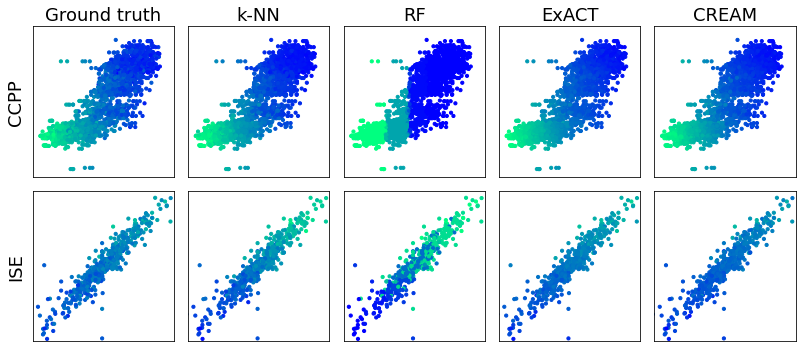

In [132]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

data = {}

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(2.25 * 5, 5))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01)

plot_num = 1

for i_dataset, (dataset, algo_params, name) in enumerate(data2[2:]):
    data[i_dataset] = {}
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    X = np.array(X)

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    knn = KNeighborsRegressor(11)
    dt = DecisionTreeRegressor(max_leaf_nodes=3)
    rf = RandomForestRegressor(n_estimators=10,max_leaf_nodes=3)
    exact = Extractor.exact(params["e_d"], params["e_th"], params["target"], gauss_components=2)
    cream = Extractor.cream(params["c_d"], 0.01, params["target"], gauss_components=3)

    clustering_algorithms = (
        ("k-NN", knn),
        #("DT", dt),
        ("RF", rf),
        ("ExACT", exact),
        ('CREAM', cream)
    )

    plt.subplot(2, len(clustering_algorithms) + 1, plot_num)
    if i_dataset == 0:
        plt.title("Ground truth", size=18)
    plt.ylabel(f"{name}", fontsize=18)

    #plt.colorbar()

    plot_num += plot(X, y, fun=get_colors2)

    for name, algorithm in clustering_algorithms:
        data[i_dataset][name] = []

        t0 = time.time()
        if name in ['ExACT', 'CREAM']:
            algorithm.fit(pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1, ignore_index=True).dropna())
            # algorithm.explain()
        else:
            algorithm.fit(X, y)
        t1 = time.time()

        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            if name in ['ExACT', 'CREAM']:
                y_pred = algorithm.predict(pd.DataFrame(X))
            else:
                y_pred = algorithm.predict(X)

        plt.subplot(2, len(clustering_algorithms) + 1, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        data[i_dataset][name] = r2_score(y, y_pred)
        plot_num += plot(X, y_pred, fun=get_colors2)
plt.tight_layout()
plt.savefig("regr.pdf", dpi=500)
plt.show()

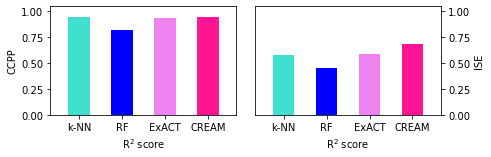

In [133]:
colors = ['turquoise', 'blue', 'violet', 'deeppink', 'red', 'orange', 'yellow', 'limegreen']
w = .15
l = len(clustering_algorithms)
xax = [i[0] for i in clustering_algorithms]
yax = [i[-1] for i in data2[2:]]

plt.figure(figsize=(7, 2))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.bar(np.linspace(0, 1.5 * w * l, l), [v for v in data[i].values()], width=w, color=colors)
    plt.xlabel(r"R$^2$ score")
    plt.ylabel(yax[i])
    plt.gca().set_xticks(np.linspace(0, 1.5 * w * l, l))
    plt.gca().set_xticklabels(xax)
    if i % 2 == 1:
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
    plt.xlim(-0.2, 1.1)
    plt.ylim(0, 1.05)

plt.subplots_adjust(wspace=0.1)
plt.savefig("regr_perf.pdf", dpi=500, bbox_inches='tight')
plt.show()